In [156]:
import numpy as np
np.random.seed(15)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [157]:
# Load data
company = 'AAPL'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,6,1)
prediction_days = 90

data = pdr.DataReader(company, 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-26,81.059998,79.125000,80.875000,79.182503,125522000.0,78.786133
2020-05-27,79.677498,78.272499,79.035004,79.527496,112945200.0,79.129402
2020-05-28,80.860001,78.907501,79.192497,79.562500,133560800.0,79.164230
2020-05-29,80.287498,79.117500,79.812500,79.485001,153598000.0,79.087120
2020-06-01,80.587502,79.302498,79.437500,80.462502,80791200.0,80.059723


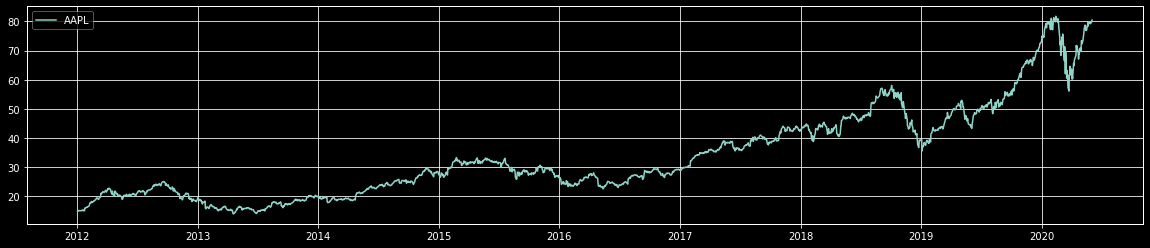

In [158]:
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(data['Close'], label=f'{company}')
plt.legend()
plt.show()

In [159]:
# Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [160]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [162]:
# Build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next price closing

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary(), '\n')
history = model.fit(x_train, y_train, epochs=10, batch_size=32, shuffle=False)

# model.save
# model.load

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 90, 50)            10400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

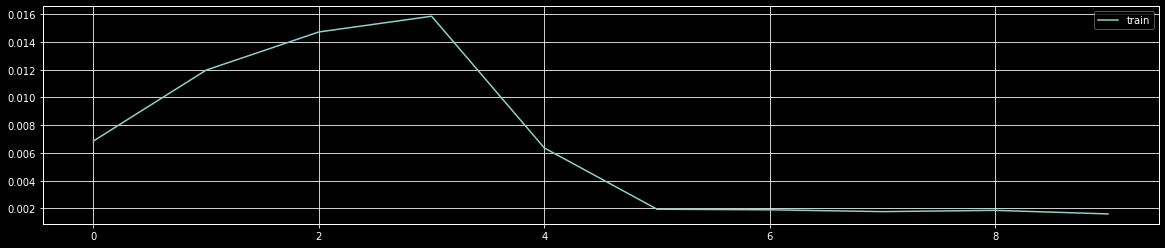

In [163]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Test the model accuracy on existing data

In [164]:
# Load test data
test_start = end + dt.timedelta(days=1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
# len(your_list) != len(set(your_list)) # check if duplicates

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values # start ASAP
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [167]:
# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

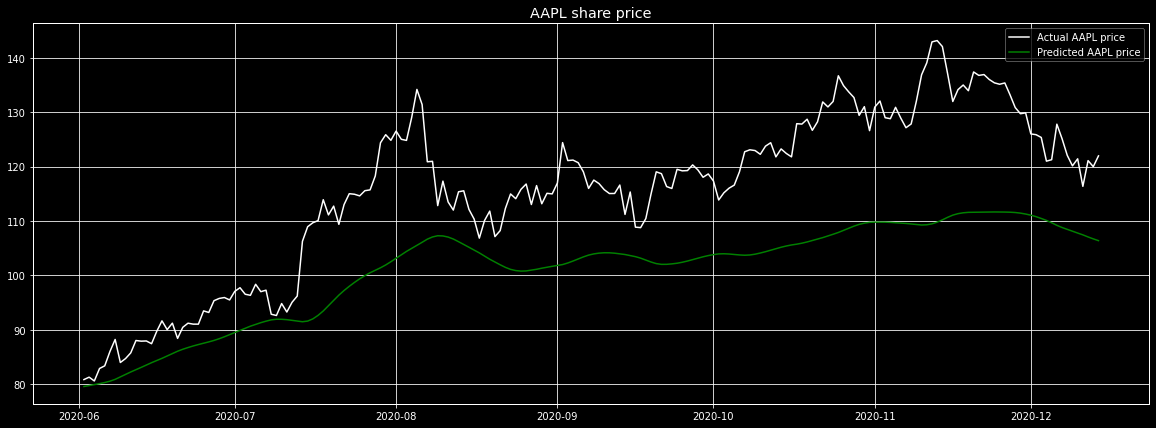

In [168]:
days = []
for i in range(len(test_data)):
    days.append(test_start + dt.timedelta(days=i))

# Plot the test predictions
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(days, actual_prices, color='white', label=f'Actual {company} price')
plt.plot(days, predicted_prices, color='green', label=f'Predicted {company} price')
plt.title(f'{company} share price')
plt.legend()
plt.show()

In [169]:
# Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [170]:
current_day = str(test_data.index[-1]).split()[0]
current_price = round(float(test_data['Close'][-1]), 2)

prediction = model.predict(real_data)
prediction = round(float(scaler.inverse_transform(prediction)), 2)
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]

print('\n Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')


 Current price:
2021-03-11 AAPL: 121.96 

Next day prediction:
2021-03-12 AAPL: 106.12


## Prophet

In [171]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [172]:
prophet_df = total_dataset.to_frame()
prophet_df.reset_index(level = 0, inplace = True)
prophet_df.columns = ['ds', 'y']

prophet = Prophet()
prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


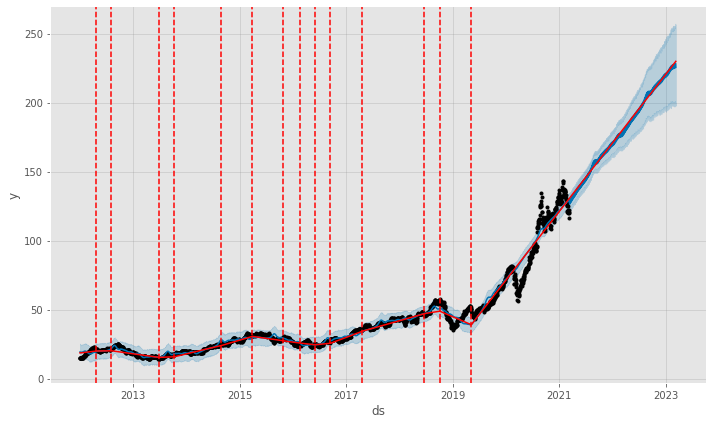

In [173]:
plt.style.use('ggplot')
future = prophet.make_future_dataframe(periods = 365*2)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

In [174]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3037,2023-03-07,229.385477,201.323382,256.469751,201.735183,257.313346,-1.284121,-1.284121,-1.284121,0.853425,0.853425,0.853425,-2.137546,-2.137546,-2.137546,0.0,0.0,0.0,228.101355
3038,2023-03-08,229.521605,199.785235,257.344256,201.784614,257.470312,-1.331101,-1.331101,-1.331101,0.863275,0.863275,0.863275,-2.194376,-2.194376,-2.194376,0.0,0.0,0.0,228.190503
3039,2023-03-09,229.657733,200.215174,256.494356,201.870887,257.627279,-1.440006,-1.440006,-1.440006,0.803441,0.803441,0.803441,-2.243447,-2.243447,-2.243447,0.0,0.0,0.0,228.217726
3040,2023-03-10,229.793861,199.802458,256.674877,201.957159,257.784245,-1.585716,-1.585716,-1.585716,0.698817,0.698817,0.698817,-2.284533,-2.284533,-2.284533,0.0,0.0,0.0,228.208145
3041,2023-03-11,229.929989,197.715299,253.694184,202.045760,257.941212,-4.322904,-4.322904,-4.322904,-2.005397,-2.005397,-2.005397,-2.317508,-2.317508,-2.317508,0.0,0.0,0.0,225.607084


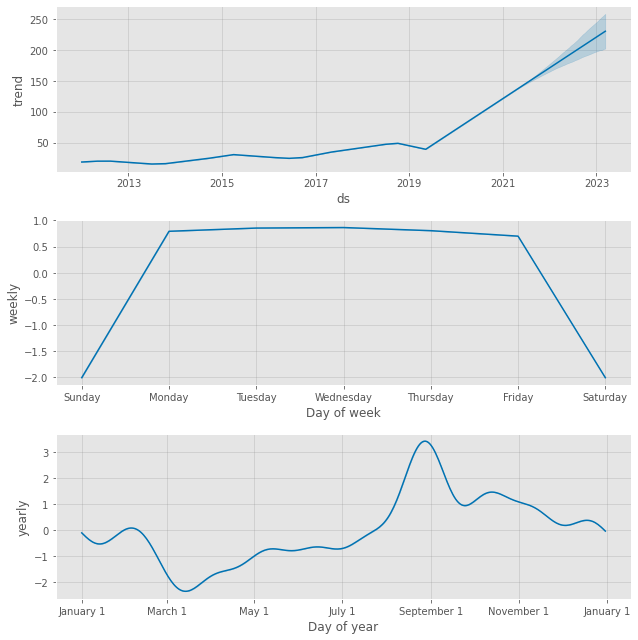

In [175]:
fig = prophet.plot_components(forecast)

In [176]:
forecast = forecast.set_index('ds')
next_day = str(test_data.index[-1] + dt.timedelta(days=1)).split()[0]
forecast.loc[[next_day]]

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2021-03-12,130.692671,123.23677,134.391202,130.692671,130.692671,-1.652919,-1.652919,-1.652919,0.698817,0.698817,0.698817,-2.351736,-2.351736,-2.351736,0.0,0.0,0.0,129.039752


In [177]:
forecast = forecast[['yhat']]

current_day = str((forecast.loc[[next_day]].index - dt.timedelta(days=1)).date[0])
current_price = round(float(test_data['Close'][-1]), 2)

prediction = round(float(forecast.loc[[next_day]]['yhat']),2)
next_day = str((forecast.loc[[next_day]].index).date[0])

print('Current price:')
print(f'{current_day} {company}: {current_price} \n')

print('Next day prediction:')
print(f'{next_day} {company}: {prediction}')

Current price:
2021-03-11 AAPL: 121.96 

Next day prediction:
2021-03-12 AAPL: 129.04
